# Data Import

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
from google.colab import files


uploaded = files.upload()

Importing hourly energy usage data and visualizing the entire dataset

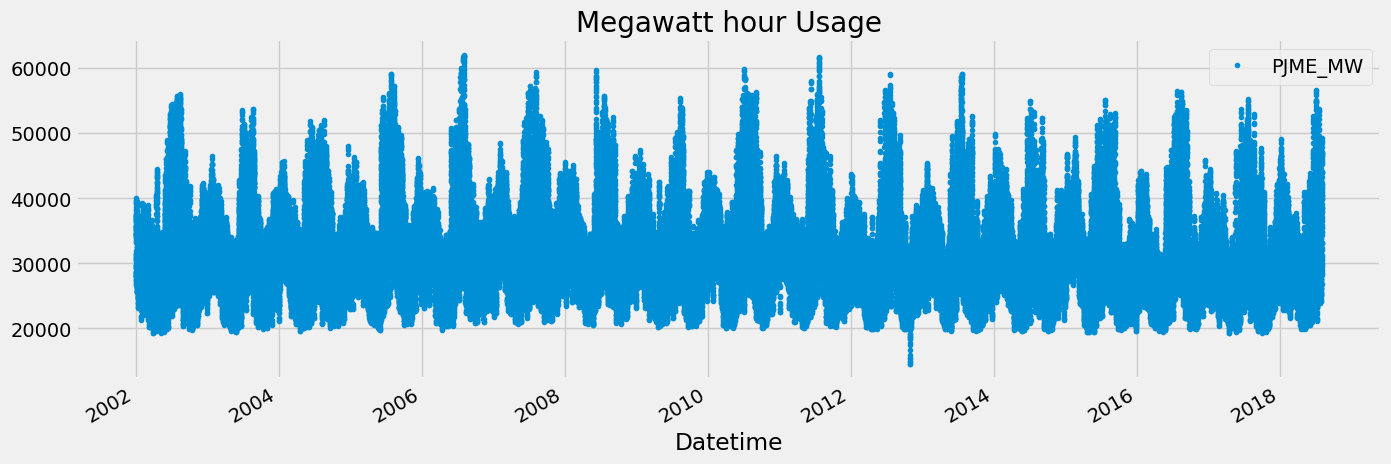

In [63]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])
plot = pjme.plot(style='.', figsize=(15,5), title='Megawatt hour Usage')


In [107]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145366 non-null  float64
 1   date        145366 non-null  object 
 2   hour        145366 non-null  int32  
 3   dayofweek   145366 non-null  int32  
 4   quarter     145366 non-null  int32  
 5   month       145366 non-null  int32  
 6   year        145366 non-null  int32  
 7   dayofyear   145366 non-null  int32  
 8   dayofmonth  145366 non-null  int32  
 9   weekofyear  145366 non-null  UInt32 
 10  is_holiday  145366 non-null  bool   
dtypes: UInt32(1), bool(1), float64(1), int32(7), object(1)
memory usage: 8.0+ MB


No missing data, which would be our main concern for a data set this large

In [64]:
pd.isnull(pjme).sum()

,0
PJME_MW,0


# XGBoost Linear Regression

Creating a set of training and testing data by date

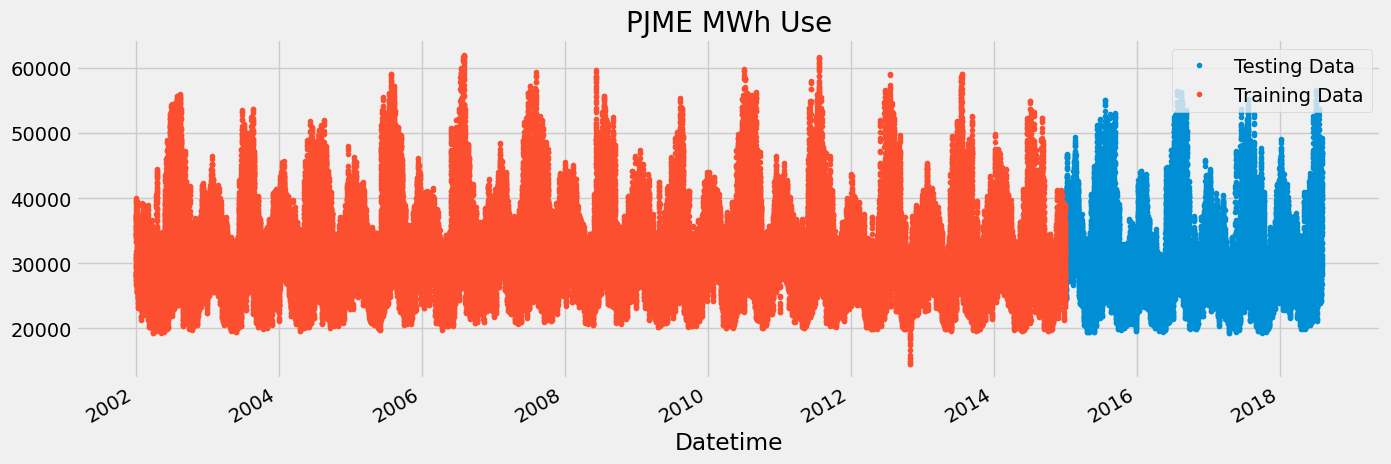

In [65]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()
plot = pjme_test \
    .rename(columns={'PJME_MW': 'Testing Data'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'Training Data'}), how='outer') \
    .plot(figsize=(15,5), title='PJME MWh Use', style='.')

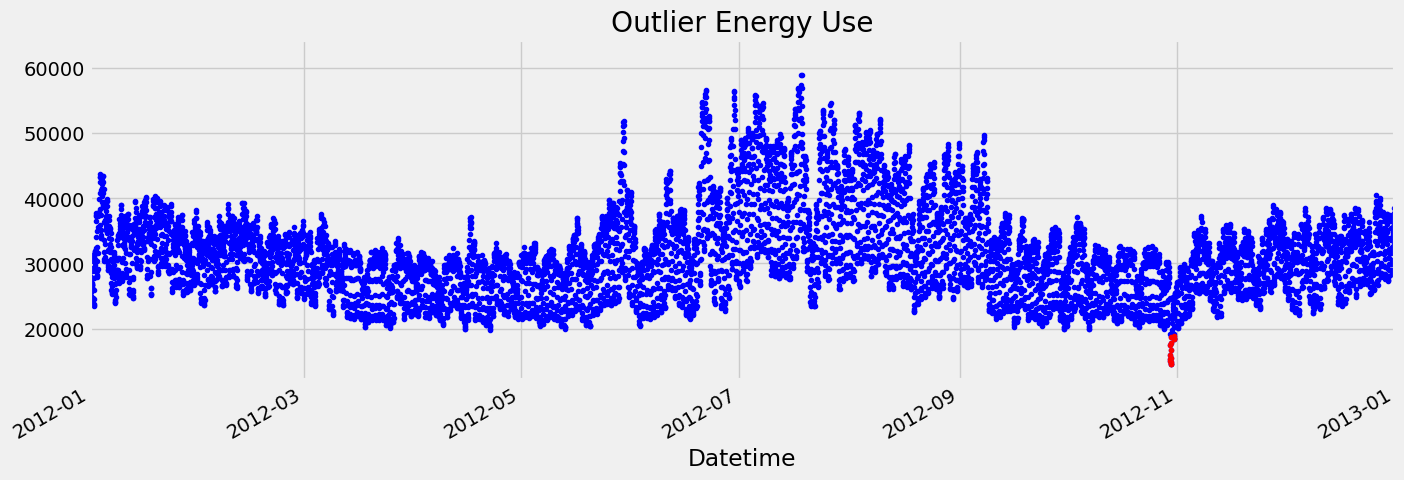

In [66]:
ax = pjme_train.plot(style='.', figsize=(15,5), color= 'b', title='Outlier Energy Use', xlim=('01-01-2012','01-01-2013'))

pjme_train.query('PJME_MW < 19000').plot(style='.', figsize=(15,5), color='r', ax=ax)

ax.legend().set_visible(False)

plt.show()

Creating additional features for our model

In [67]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth', 'weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [68]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

Pairplot to show each created feature versus the megawatt hour usage, with tint based on hour of the day

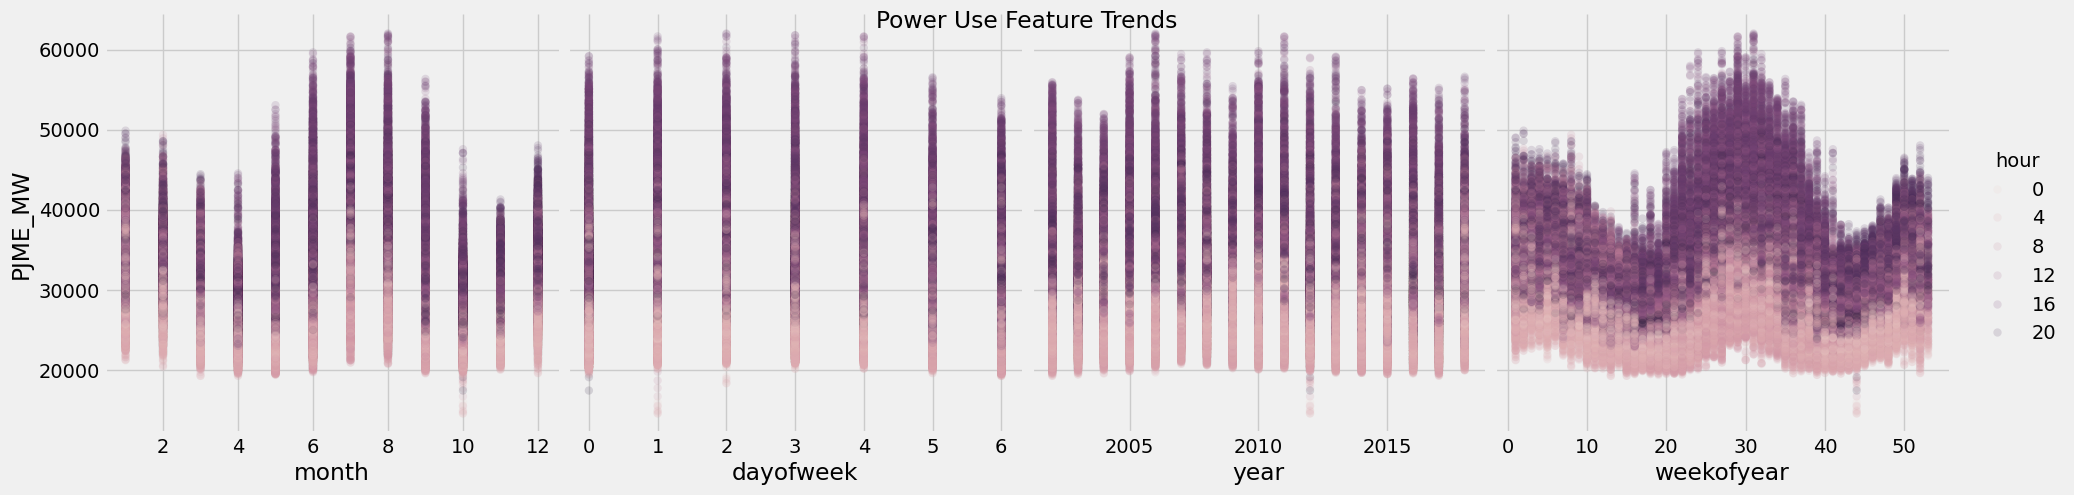

In [69]:
sns.pairplot(features_and_target, hue='hour', x_vars=['month','dayofweek', 'year','weekofyear'], y_vars='PJME_MW', height=5, plot_kws={'alpha':0.15, 'linewidth':0})
plt.suptitle('Power Use Feature Trends')
plt.show()

Boxplot showing where most MWh data falls throughout the day

<Axes: xlabel='hour', ylabel='PJME_MW'>

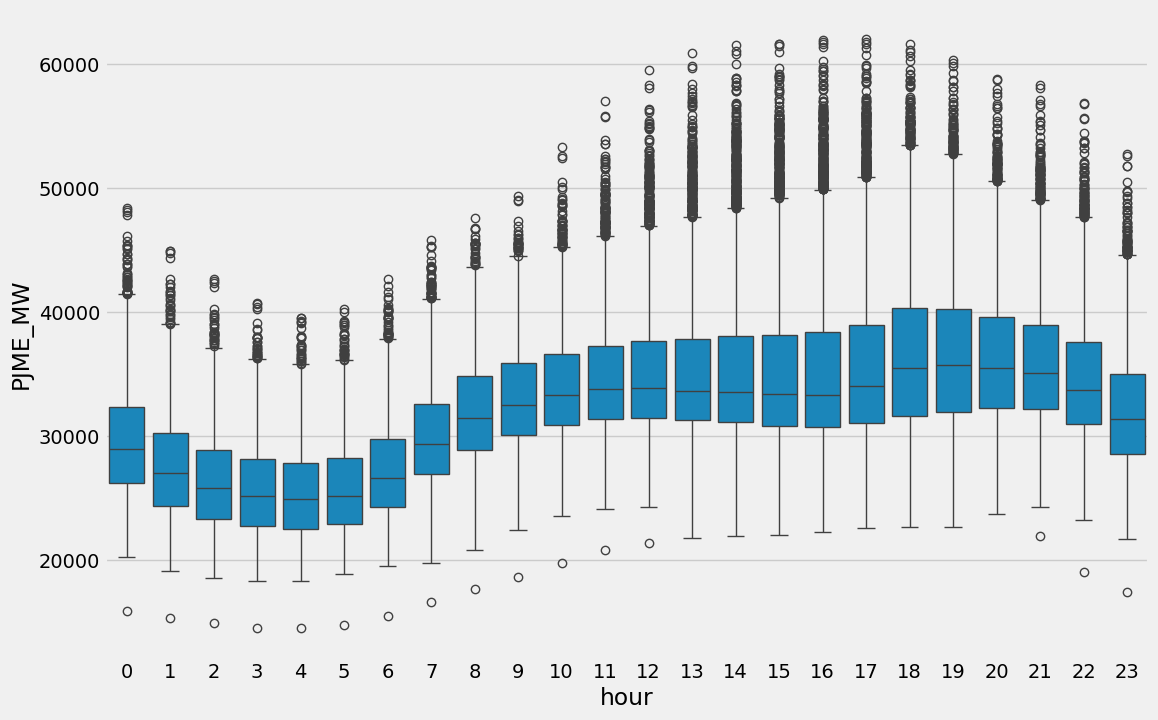

In [70]:
plt.figure(figsize = (12 , 8))
sns.boxplot(x = "hour" , y = "PJME_MW" , data = pjme_train)

In [71]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Importance in our regression model

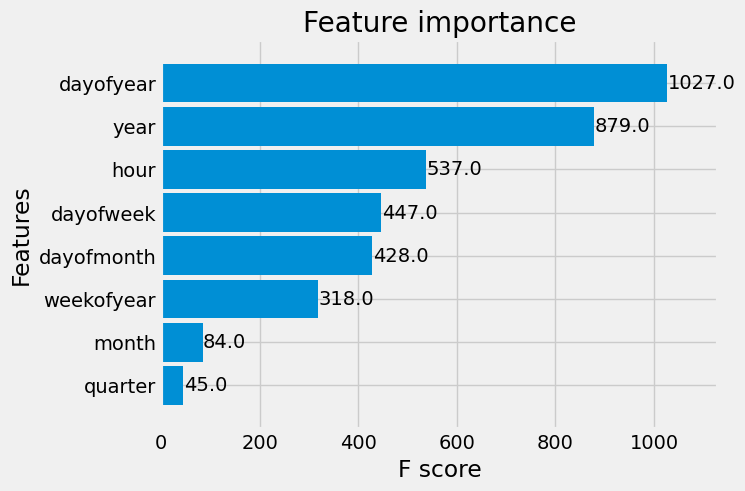

In [72]:
plot = plot_importance(reg, height=0.9)

In [73]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

Comparing the actual data to our predictions on a large scale, as well as zoomed into 1 week of January and July

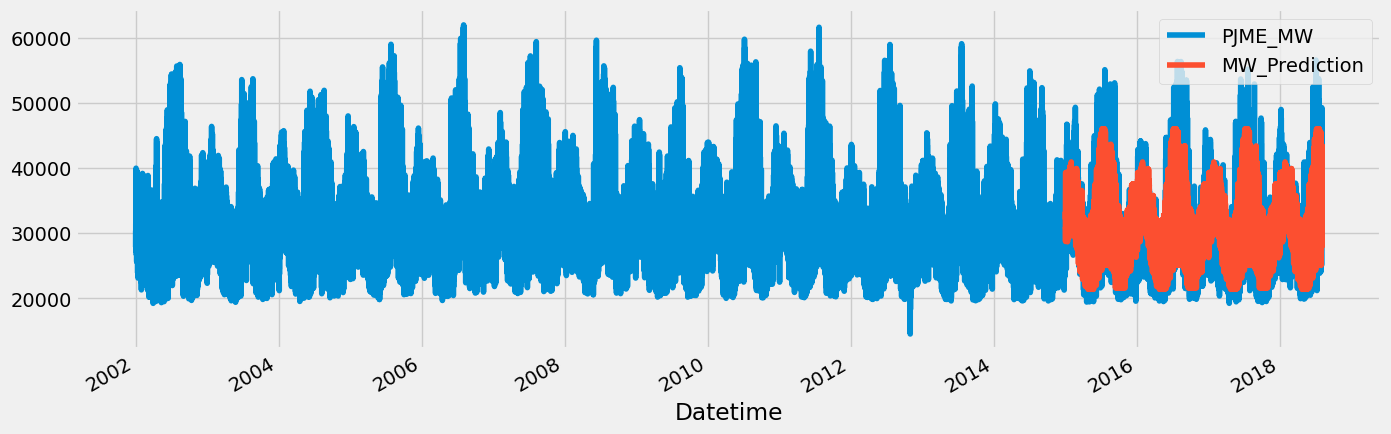

In [74]:
plot = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

Plotting our predictions vs one month of actual data

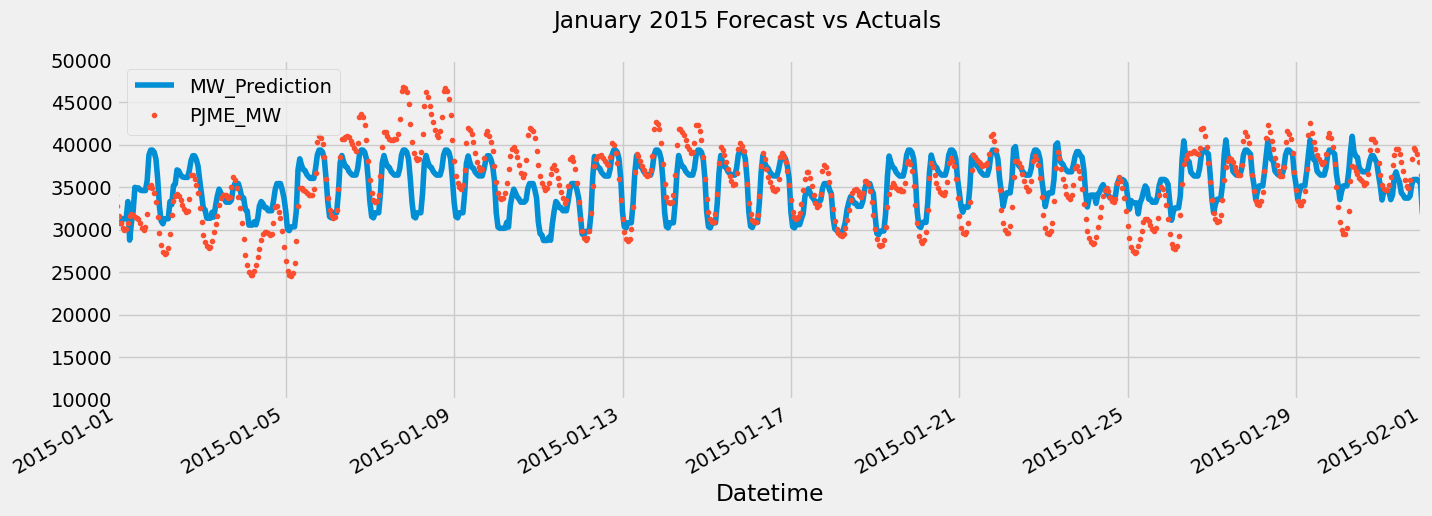

In [75]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(10000, 50000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

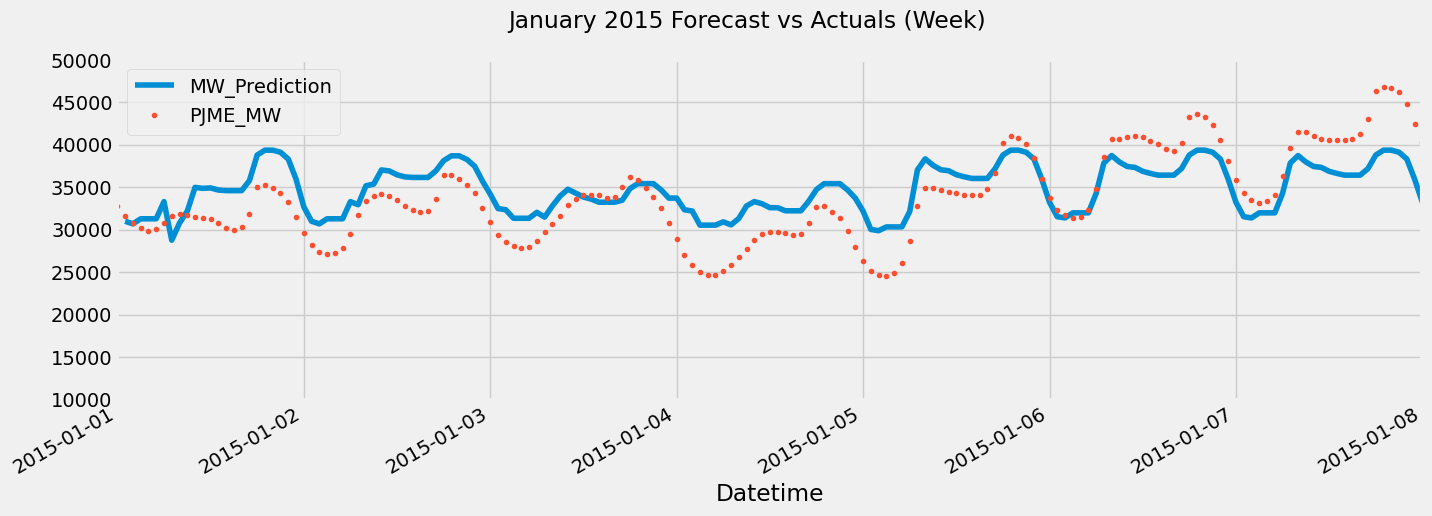

In [76]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(10000, 50000)
plot = plt.suptitle('January 2015 Forecast vs Actuals (Week)')

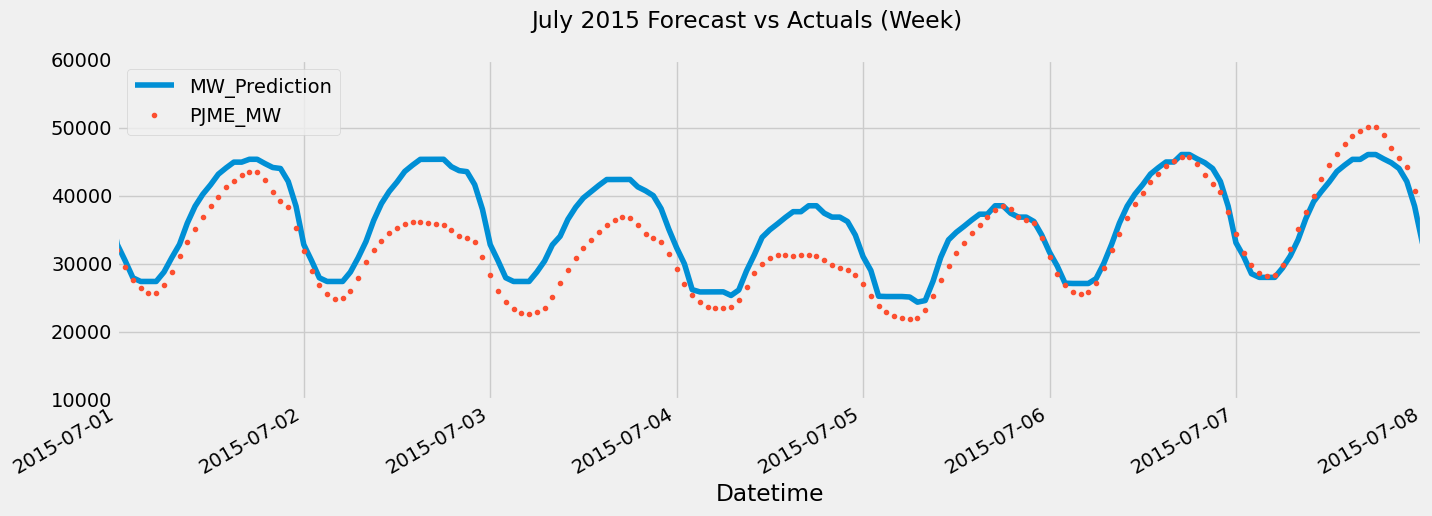

In [77]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(10000, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('July 2015 Forecast vs Actuals (Week)')

####Error Metrics

Observing model accuracy using mean squared error, mean absolute error, and mean absolute percentage error. These metrics were chosen instead of model accuracy since we want to see how close the model can get to numerical data rather than how many exact predictions we find.

In [78]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14055329.714256588

In [79]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2905.541158635075

In [80]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.239324261253785

Worst and best predictions by accuracy

In [81]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37517.796875 -9117.839681  9117.839681
2017 2     24          26445.083333   34674.246094 -8229.161458  8229.161458
           25          24344.458333   32168.185547 -7823.726562  7823.726562
           20          27070.583333   34739.832031 -7669.247314  7669.247314
           23          27663.416667   35189.988281 -7526.572591  7526.572591
           19          24555.500000   32075.916016 -7520.415690  7520.415690
2018 2     21          27572.500000   35071.636719 -7499.138509  7499.138509
2017 2     28          28297.875000   35777.996094 -7480.123128  7480.123128
2015 12    25          24466.083333   31934.242188 -7468.158447  7468.158447
2017 5     29          24528.416667   31898.537109 -7370.119873  7370.119873

In [82]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 12    30          32213.458333   32181.333984   32.125244  293.829183
     10    27          28611.166667   28468.591797  142.576579  395.899007
2017 10    24          28657.416667   28500.578125  156.839274  418.409749
2015 10    28          28500.958333   28500.578125    0.380941  437.252360
     5     6           28948.666667   28924.179688   24.486898  467.199788
2016 8     8           36256.041667   36075.062500  180.978190  565.314616
2017 9     14          32033.875000   31962.031250   71.842448  596.341634
     5     2           28546.916667   28924.179688 -377.263102  596.743408
     8     12          31822.666667   32056.876953 -234.211263  597.051595
2016 12    12          32757.208333   33159.648438 -402.439290  597.560872

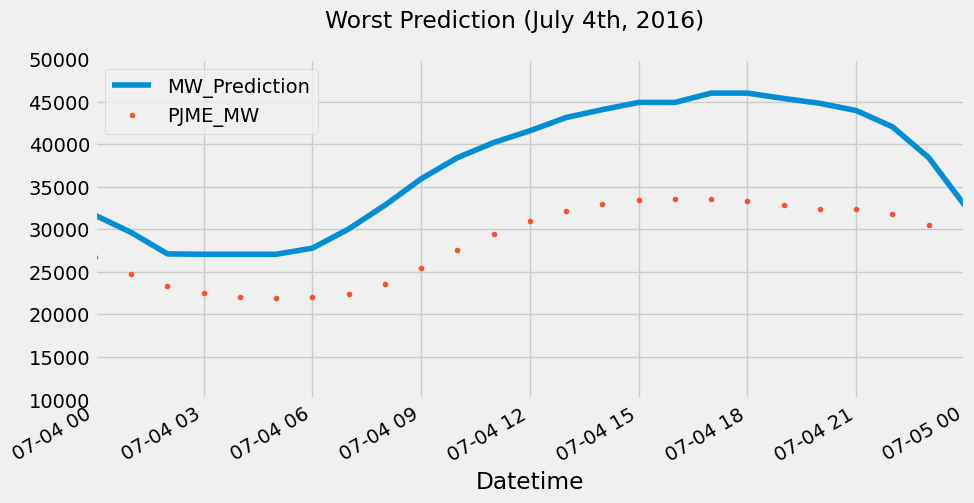

In [83]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(10000, 50000)
ax.set_xbound(lower='07-4-2016', upper='07-5-2016')
plot = plt.suptitle('Worst Prediction (July 4th, 2016)')

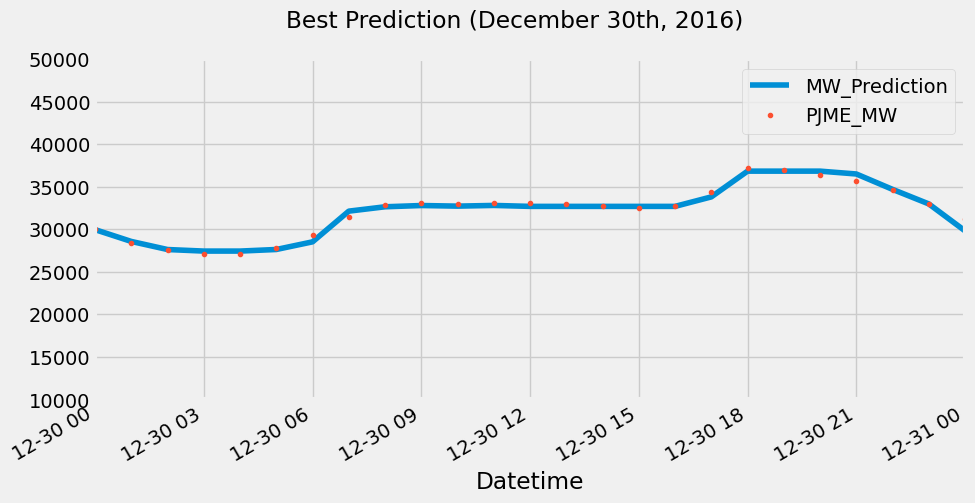

In [84]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(10000, 50000)
ax.set_xbound(lower='12-30-2016', upper='12-31-2016')
plot = plt.suptitle('Best Prediction (December 30th, 2016)')

# Prophet Time Series Forecast

We create a new model (also linear regression) using Facebook's Prophet library. This library is supposedly good at dealing with NaN values (which we don't have, but may assist when outright deleting outliers) and seasonal trends.

In [85]:
pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}).head()

,ds,y,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
1,2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2,2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
3,2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
4,2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [86]:
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/rx8y3_um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/li6s_u6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79834', 'data', 'file=/tmp/tmp83lqlupb/rx8y3_um.json', 'init=/tmp/tmp83lqlupb/li6s_u6d.json', 'output', 'file=/tmp/tmp83lqlupb/prophet_modelws65h7tu/prophet_model-20240810032929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [87]:
pjme_prophet1 = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))
pjme_prophet1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23670.463976,32530.303393,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22519.605043,31269.731947,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21329.705274,30252.173956,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21267.035290,30548.455655,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21759.071422,31184.083248,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


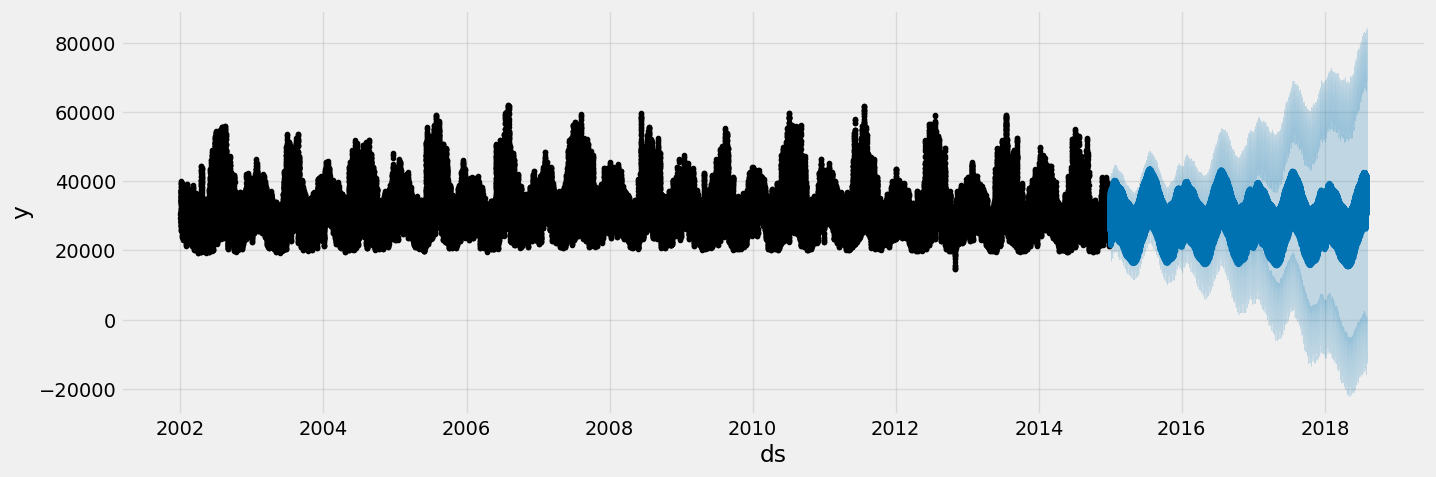

In [88]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_prophet1, ax=ax)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

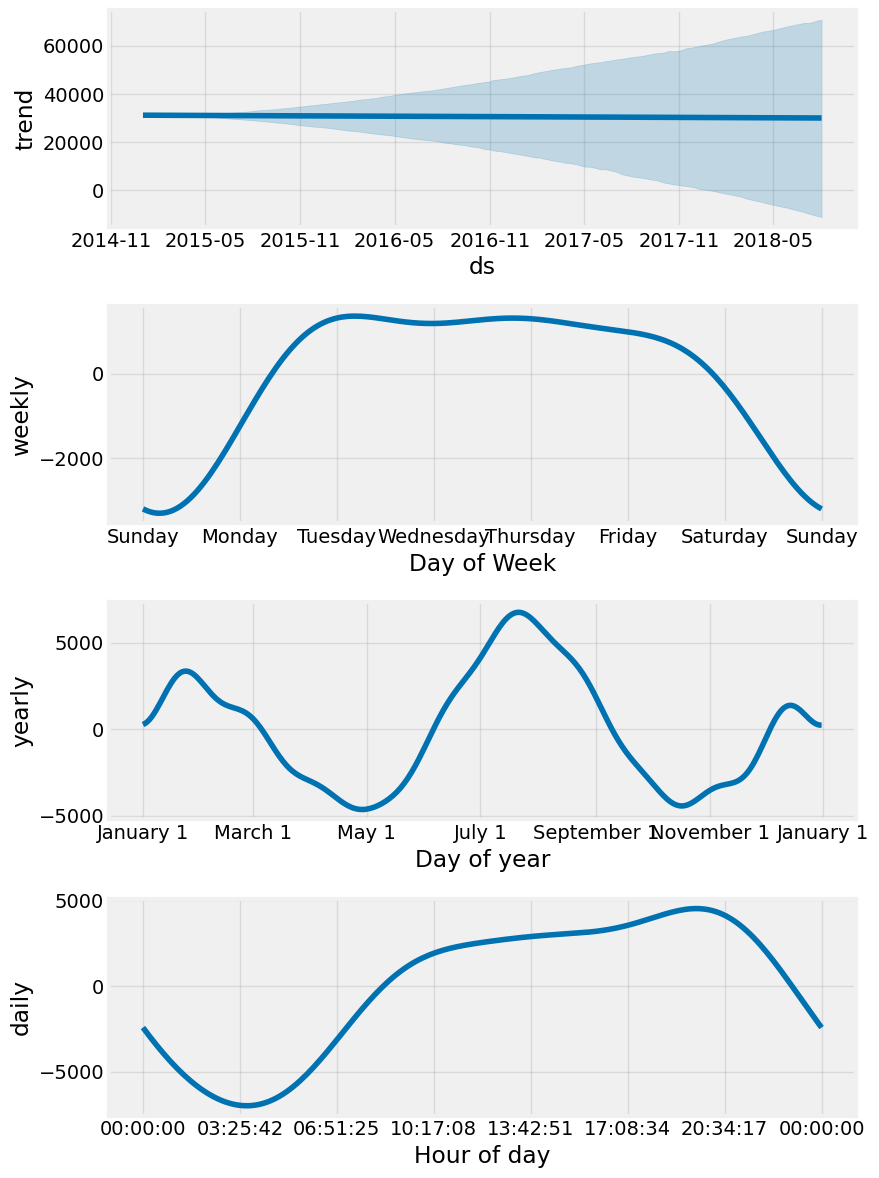

In [89]:
fig = model.plot_components(pjme_prophet1)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


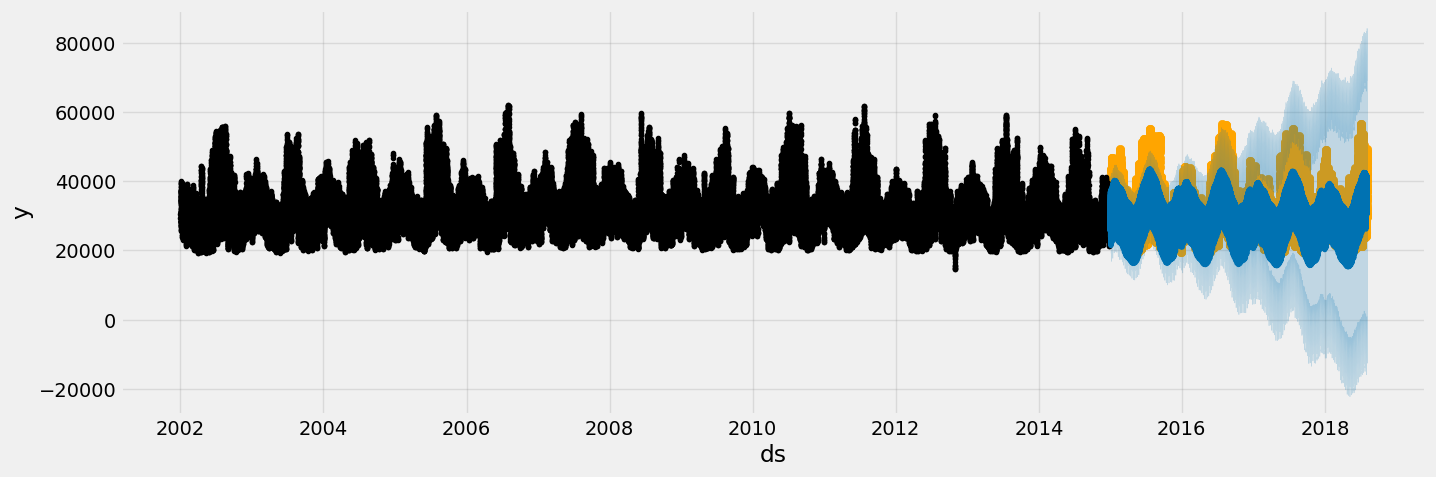

In [90]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='orange')
fig = model.plot(pjme_prophet1, ax=ax)

Comparing predicted values to our actual values for January

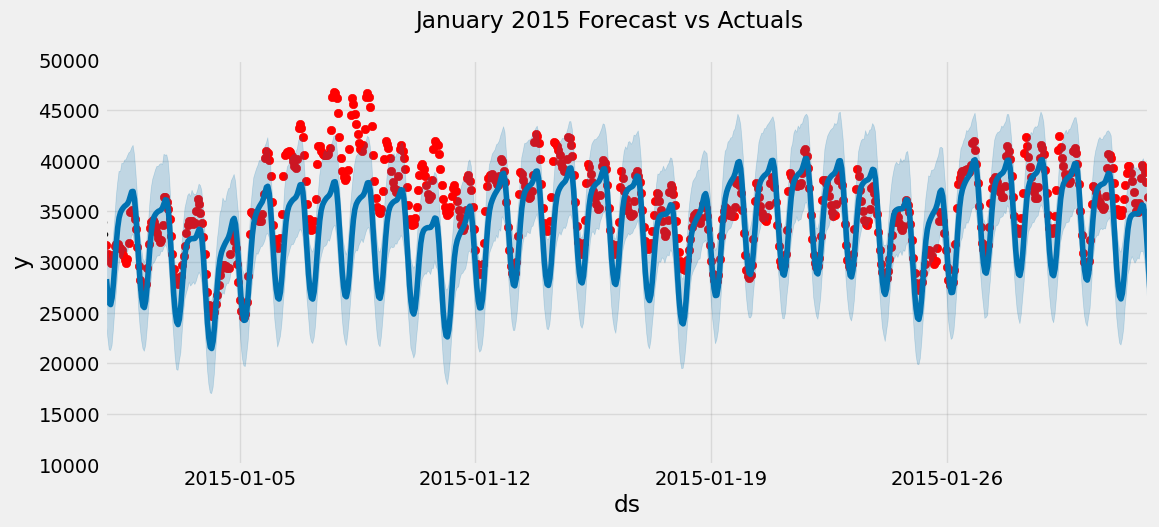

In [91]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(12)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_prophet1, ax=ax)
lower_bound = pd.to_datetime('01-01-2015')
upper_bound = pd.to_datetime('02-01-2015')

ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(10000, 50000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

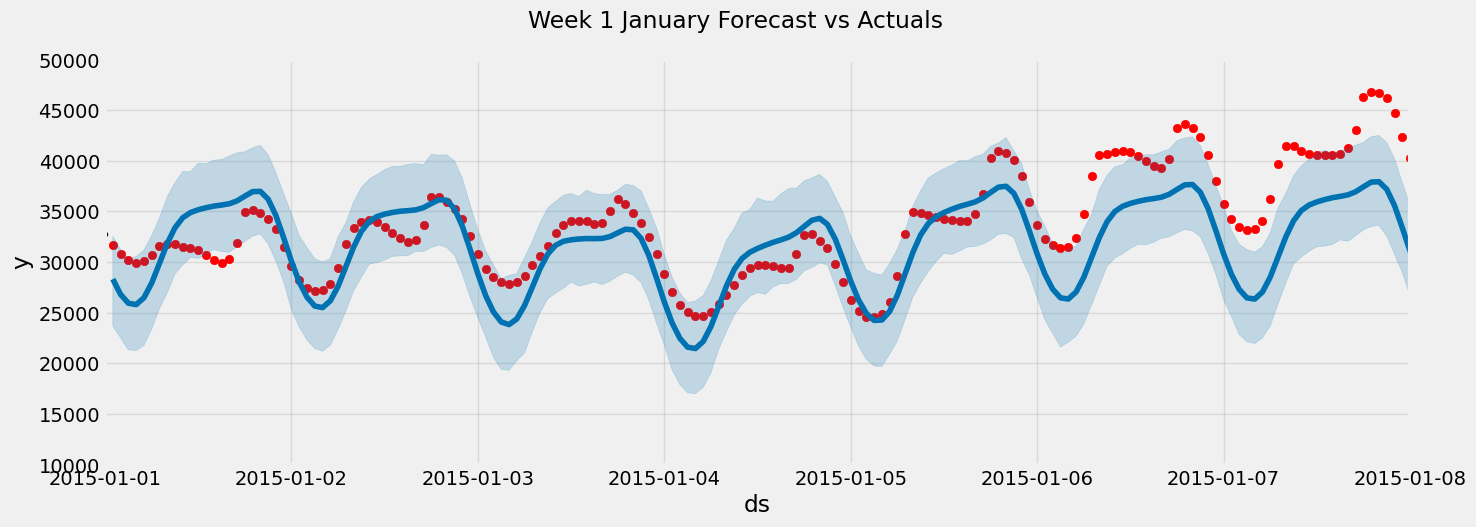

In [92]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_prophet1, ax=ax)
lower_bound = pd.to_datetime('01-01-2015')
upper_bound = pd.to_datetime('01-08-2015')

ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(10000, 50000)
plot = plt.suptitle('Week 1 January Forecast vs Actuals')

And comparing our predictions to July

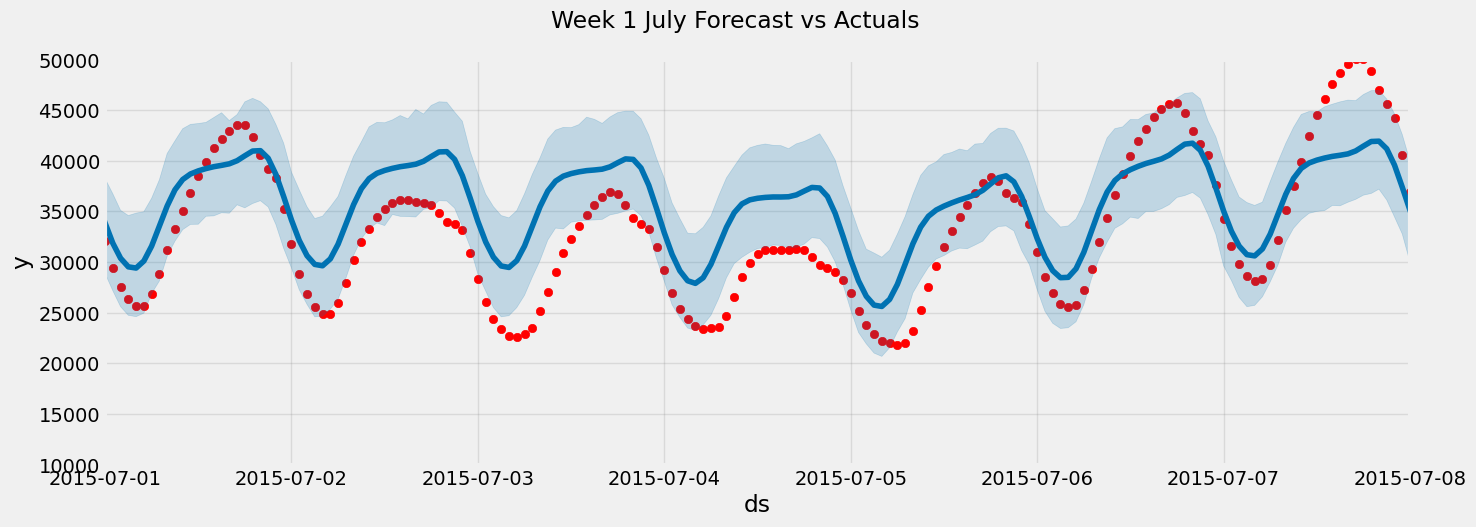

In [93]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_prophet1, ax=ax)
lower_bound = pd.to_datetime('07-01-2015')
upper_bound = pd.to_datetime('07-08-2015')

ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(10000, 50000)
plot = plt.suptitle('Week 1 July Forecast vs Actuals')

Error Metrics

In [94]:
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_prophet1['yhat'])

43784240.02744754

In [95]:
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_prophet1['yhat'])

5181.911537928106

In [96]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_prophet1['yhat'])

16.512003880182647

Importing pandas calendar to address some of our worst predicted days

In [97]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [98]:
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)

holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

holiday_df.head()

,ds,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
0,2003-01-01 00:00:00,0,2,1,1,2003,1,1,1,USFederalHoliday
1,2002-12-25 01:00:00,1,2,4,12,2002,359,25,52,USFederalHoliday
2,2002-12-25 02:00:00,2,2,4,12,2002,359,25,52,USFederalHoliday
3,2002-12-25 03:00:00,3,2,4,12,2002,359,25,52,USFederalHoliday
4,2002-12-25 04:00:00,4,2,4,12,2002,359,25,52,USFederalHoliday


In [99]:
holiday_model = Prophet(holidays=holiday_df)
holiday_model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/r3a0dc4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/w41c8v8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63436', 'data', 'file=/tmp/tmp83lqlupb/r3a0dc4c.json', 'init=/tmp/tmp83lqlupb/w41c8v8f.json', 'output', 'file=/tmp/tmp83lqlupb/prophet_model1ubu5yi4/prophet_model-20240810033128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [100]:
pjme_holidays = holiday_model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

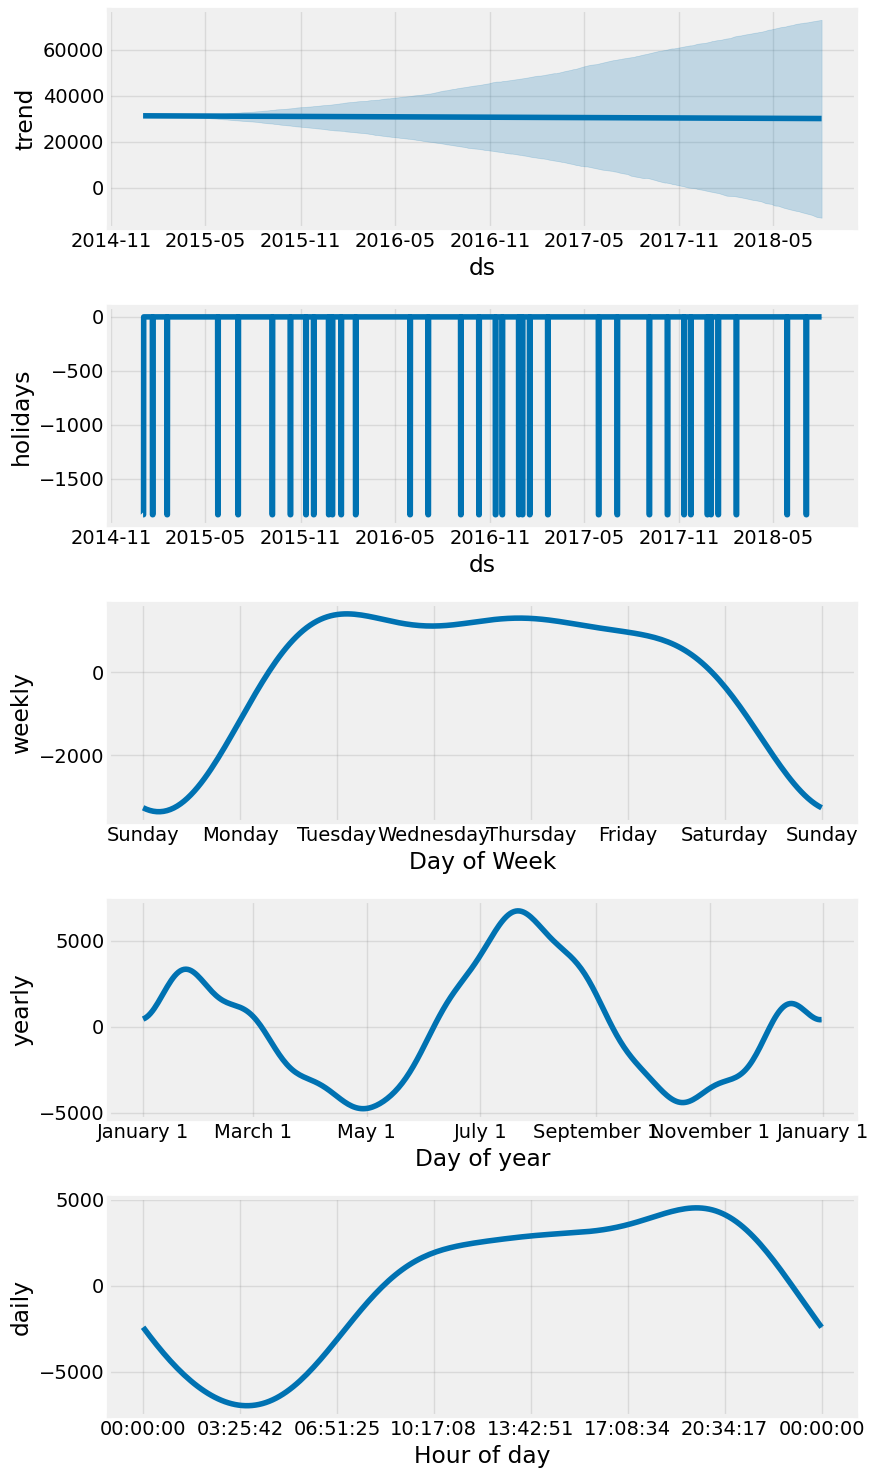

In [101]:
fig2 = holiday_model.plot_components(pjme_holidays)

#### Error Metrics

In [102]:
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_holidays['yhat'])

43957492.85018296

In [103]:
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_holidays['yhat'])

5192.348054859118

In [104]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_holidays['yhat'])

16.541420012252114

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


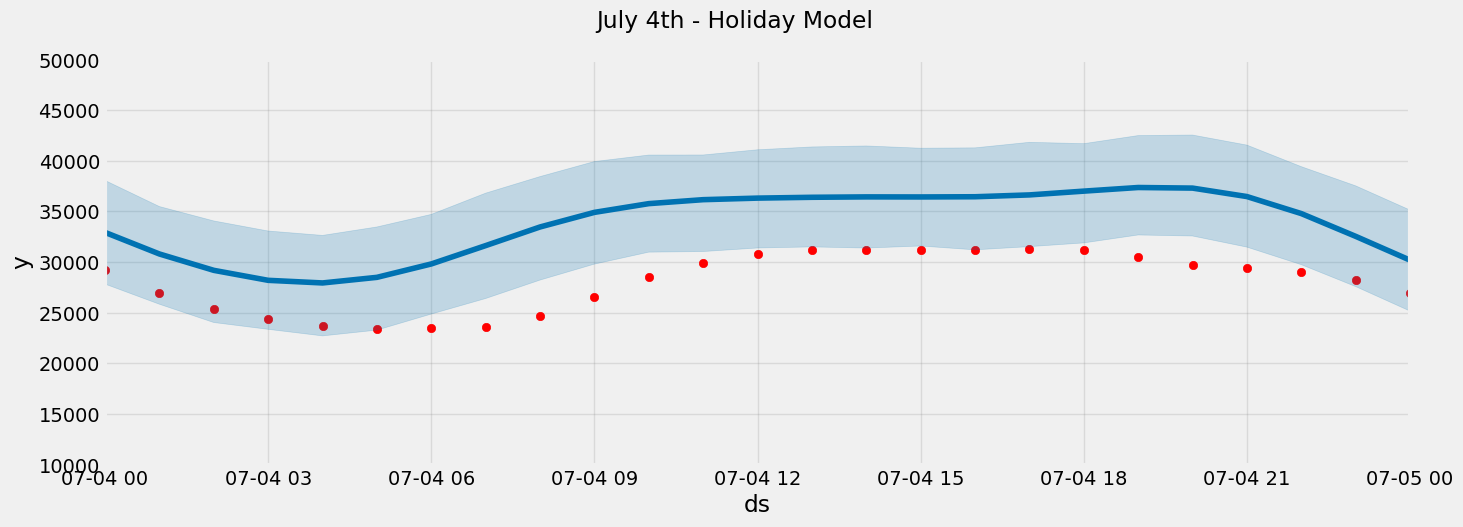

In [105]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_holidays, ax=ax)
lower_bound = pd.to_datetime('07-04-2015')
upper_bound = pd.to_datetime('07-05-2015')

ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(10000, 50000)
plot = plt.suptitle('July 4th - Holiday Model')

# Prophet Time Series Analysis #2

Clean the Hurricane Sandy data from the original dataset and create a new predictive model

In [106]:
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW_clean':'y'}))

pjme_clean = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/4yxf6ehm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83lqlupb/xw5v85vw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33438', 'data', 'file=/tmp/tmp83lqlupb/4yxf6ehm.json', 'init=/tmp/tmp83lqlupb/xw5v85vw.json', 'output', 'file=/tmp/tmp83lqlupb/prophet_modelnox95sio/prophet_model-20240810033332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Error Metrics

We can see a marginal improvement over our holiday model by accounting for the Hurricane Sandy outliers - however, it is very negligible.

In [108]:
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_clean['yhat'])

43776755.40194218

In [109]:
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_clean['yhat'])

5182.972754880821

In [110]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_clean['yhat'])

16.504536779898014